<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Spectrum/blob/main/SubtractedSpectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


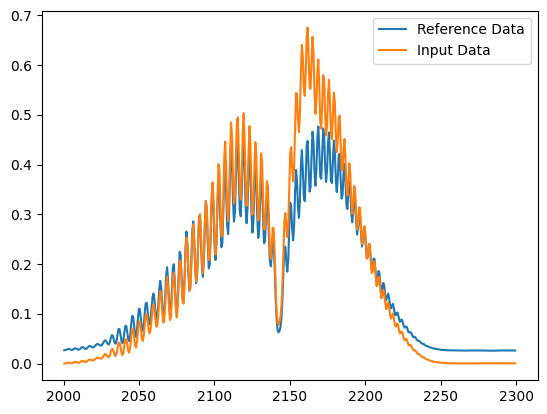

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm, cauchy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define Pseudo-Voigt Distribution
def pseudo_voigt(delta, sigma):
    g = (delta**5 + sigma**5 + 2.69296*sigma**4*delta +
         2.42843*sigma**3*delta**2 + 4.47163*sigma**2*delta**3 +
         0.07842*sigma*delta**4)**(1/5)
    eta = delta / g
    eta = eta * (1.36603 - 0.47719*eta + 0.11116*eta**2)
    return (1 - eta) * norm(0, g).pdf(0) + eta * cauchy(0, g).pdf(0)

# Gaussian Function
def gaussian(A, sigma, xp, x):
    return A * np.exp(-(((x - xp) / sigma) ** 2))

# Summation for Gaussian Components
def sum_gaussian(coeffs, fregapha, sigma, B0, B1, D3, x):
    return sum(coeff * gaussian(1, sigma, fregapha + (B0 + B1) * i + (B0 - B1) * i**2 - 4*D3*i**3, x)
               for i, coeff in enumerate(coeffs))

# Data loading
reference_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0061.0055.dpt"
input_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005.dpt"

# Example placeholder for data import
def import_data(file_path):
    # Replace this with actual data loading code
    return pd.read_csv(file_path, delimiter="\t", header=None)

reference_data = import_data(reference_file)
input_data = import_data(input_file)

# Spectrum selection
spectrum_min, spectrum_max = 2000.0, 2300.0
reference_selected = reference_data[(reference_data[0] >= spectrum_min) & (reference_data[0] <= spectrum_max)]
input_selected = input_data[(input_data[0] >= spectrum_min) & (input_data[0] <= spectrum_max)]

def fit_model(x_data, y_data):
    def model(x, *params):
        coeffs = params[:30]
        fregapha, sigma, B0, B1, D3 = params[30:]
        return sum_gaussian(coeffs, fregapha, sigma, B0, B1, D3, x)

    initial_params = [0.5] * 30 + [2142.0, 1.5, 2.0, 2.0, 0.0001]

    try:
        popt, _ = curve_fit(model, x_data, y_data, p0=initial_params,
                            bounds=([0]*30 + [2000.0, 0.1, 0.1, 0.1, 0],
                                    [1]*30 + [2300.0, 10.0, 10.0, 10.0, 1]),
                            maxfev=100000)
    except RuntimeError as e:
        print("Fitting failed:", e)
        popt = initial_params  # Return initial guesses if fitting fails
    return popt


# Fit the reference and input data
x_ref = reference_selected[0].values
y_ref = reference_selected[1].values
x_in = input_selected[0].values
y_in = input_selected[1].values

# Fit reference data
params_ref = fit_model(x_ref, y_ref)

# Fit input data using the same model
params_in = fit_model(x_in, y_in)

# Plot data
plt.plot(x_ref, y_ref, label='Reference Data')
plt.plot(x_in, y_in, label='Input Data')
plt.legend()
plt.show()


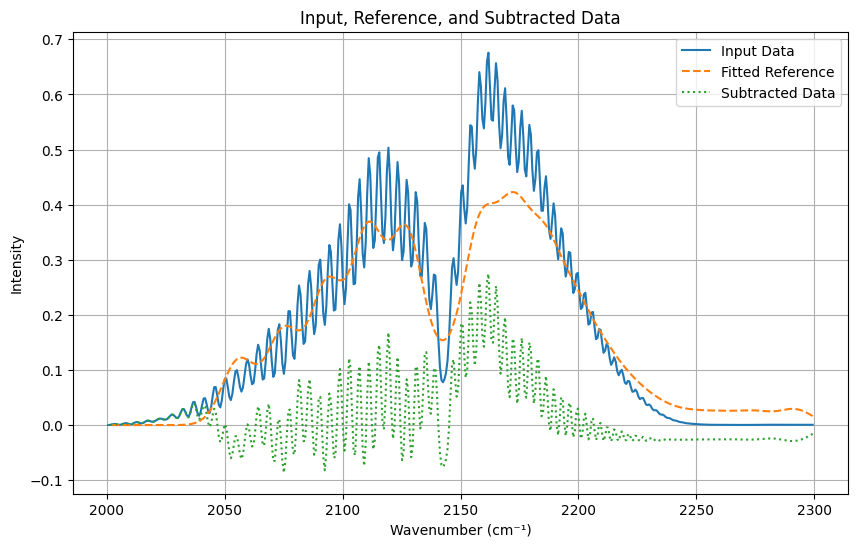

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm, cauchy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define Gaussian Function
def gaussian(A, sigma, xp, x):
    return A * np.exp(-(((x - xp) / sigma) ** 2))

# Summation for Gaussian Components
def sum_gaussian(coeffs, fregapha, sigma, B0, B1, D3, x):
    return sum(coeff * gaussian(1, sigma, fregapha + (B0 + B1) * i + (B0 - B1) * i**2 - 4*D3*i**3, x)
               for i, coeff in enumerate(coeffs))

# Data loading
def import_data(file_path):
    return pd.read_csv(file_path, delimiter="\t", header=None)

reference_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0061.0055.dpt"
input_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005.dpt"

reference_data = import_data(reference_file)
input_data = import_data(input_file)

# Spectrum selection
spectrum_min, spectrum_max = 2000.0, 2300.0
reference_selected = reference_data[(reference_data[0] >= spectrum_min) & (reference_data[0] <= spectrum_max)]
input_selected = input_data[(input_data[0] >= spectrum_min) & (input_data[0] <= spectrum_max)]

x_ref, y_ref = reference_selected[0].values, reference_selected[1].values
x_in, y_in = input_selected[0].values, input_selected[1].values

# Fit Model Function
def fit_model(x_data, y_data):
    def model(x, *params):
        coeffs = params[:30]
        fregapha, sigma, B0, B1, D3 = params[30:]
        return sum_gaussian(coeffs, fregapha, sigma, B0, B1, D3, x)

    initial_params = [0.5] * 30 + [2142.0, 1.5, 2.0, 2.0, 0.0001]
    popt, _ = curve_fit(model, x_data, y_data, p0=initial_params,
                        bounds=([0]*30 + [2000.0, 0.1, 0.1, 0.1, 0],
                                [1]*30 + [2300.0, 10.0, 10.0, 10.0, 1]),
                        maxfev=100000)
    return popt

# Fit the reference and input data
params_ref = fit_model(x_ref, y_ref)
params_in = fit_model(x_in, y_in)

# Generate the fitted reference spectrum
def model(x, *params):
    coeffs = params[:30]
    fregapha, sigma, B0, B1, D3 = params[30:]
    return sum_gaussian(coeffs, fregapha, sigma, B0, B1, D3, x)

fitted_ref = model(x_in, *params_ref)

# Subtract the fitted reference from the input data
subtracted_data = y_in - fitted_ref

# Save the subtracted data to a file
subtracted_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005_subtracted.txt"
np.savetxt(subtracted_file, np.column_stack((x_in, subtracted_data)), delimiter="\t", fmt="%.6f")

# Plot the data for visualization
plt.figure(figsize=(10, 6))
plt.plot(x_in, y_in, label="Input Data")
plt.plot(x_in, fitted_ref, label="Fitted Reference", linestyle="--")
plt.plot(x_in, subtracted_data, label="Subtracted Data", linestyle=":")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("Input, Reference, and Subtracted Data")
plt.legend()
plt.grid()
plt.show()


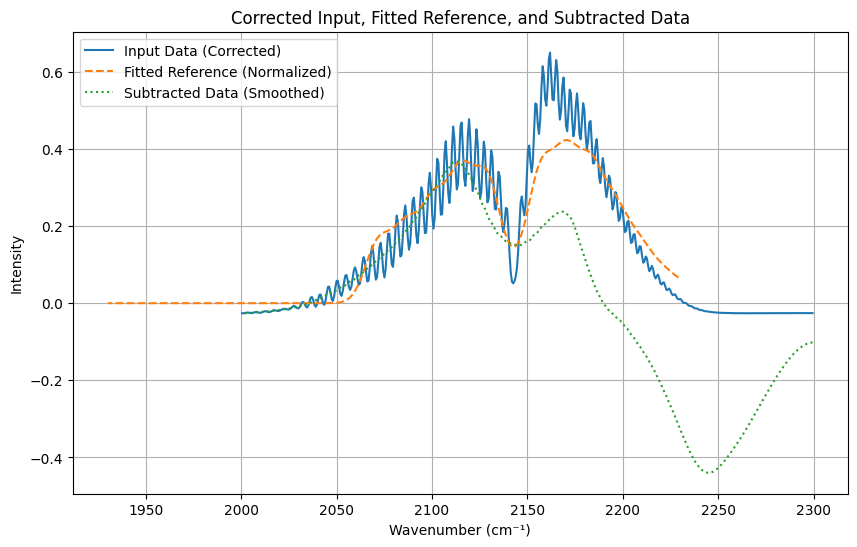

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm, cauchy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Define Gaussian Function
def gaussian(A, sigma, xp, x):
    return A * np.exp(-(((x - xp) / sigma) ** 2))

# Define Pseudo-Voigt Profile
def pseudo_voigt(A, sigma, delta, xp, x):
    g = (delta**5 + sigma**5 + 2.69296 * sigma**4 * delta +
         2.42843 * sigma**3 * delta**2 + 4.47163 * sigma**2 * delta**3 +
         0.07842 * sigma * delta**4)**(1 / 5)
    eta = delta / g
    eta = eta * (1.36603 - 0.47719 * eta + 0.11116 * eta**2)
    return A * ((1 - eta) * norm.pdf(x - xp, scale=g) + eta * cauchy.pdf(x - xp, scale=g))

# Combined Gaussian and Pseudo-Voigt Summation
def sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode='gaussian'):
    def COEJBM(fregapha, mj, B0, B1, D3):
        return fregapha + (B0 + B1) * mj + (B0 - B1) * mj**2 - 4 * D3 * mj**3

    if mode == 'gaussian':
        return sum(coeff * gaussian(1, sigma, COEJBM(fregapha, i, B0, B1, D3), x)
                   for i, coeff in enumerate(coeffs))
    elif mode == 'voigt':
        return sum(coeff * pseudo_voigt(1, sigma, delta, COEJBM(fregapha, i, B0, B1, D3), x)
                   for i, coeff in enumerate(coeffs))

# Data loading
def import_data(file_path):
    return pd.read_csv(file_path, delimiter="\t", header=None)

# Files
reference_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0061.0055.dpt"  # Update with your file path
input_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005.dpt"

reference_data = import_data(reference_file)
input_data = import_data(input_file)

# Spectrum selection
spectrum_min, spectrum_max = 2000.0, 2300.0
reference_selected = reference_data[(reference_data[0] >= spectrum_min) & (reference_data[0] <= spectrum_max)]
input_selected = input_data[(input_data[0] >= spectrum_min) & (input_data[0] <= spectrum_max)]

x_ref, y_ref = reference_selected[0].values, reference_selected[1].values
x_in, y_in = input_selected[0].values, input_selected[1].values

# Background Correction
background = np.mean(y_ref[(x_ref >= 2250) & (x_ref <= 2300)])
y_in_corrected = y_in - background

# Fit Model Function
def fit_model(x_data, y_data, mode='gaussian'):
    def model(x, *params):
        coeffs = params[:30]
        fregapha, sigma, delta, B0, B1, D3 = params[30:]
        return sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode=mode)

    initial_params = [0.5] * 30 + [2142.0, 1.5, 1.0, 2.0, 2.0, 0.0001]
    bounds = ([0]*30 + [2000.0, 0.1, 0.1, 0.1, 0.1, 0.0],
              [1]*30 + [2300.0, 10.0, 10.0, 10.0, 10.0, 1.0])

    popt, _ = curve_fit(model, x_data, y_data, p0=initial_params, bounds=bounds, maxfev=100000)
    return popt

# Fit the reference and input data
params_ref = fit_model(x_ref, y_ref, mode='gaussian')
params_in = fit_model(x_in, y_in_corrected, mode='gaussian')

# Frequency Shift Correction
frecorr = params_in[30] - params_ref[30]
x_in_shifted = x_in - frecorr

# Generate the fitted reference spectrum
def model(x, *params):
    coeffs = params[:30]
    fregapha, sigma, delta, B0, B1, D3 = params[30:]
    return sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode='gaussian')

fitted_ref = model(x_in_shifted, *params_ref)

# Normalize Intensity
norm_factor = np.sum(y_in_corrected) / np.sum(fitted_ref)
fitted_ref_normalized = fitted_ref * norm_factor

# Subtract the fitted reference from the input data
subtracted_data = y_in_corrected - fitted_ref_normalized

# Apply Smoothing
subtracted_data_smoothed = savgol_filter(subtracted_data, window_length=101, polyorder=3)

# Save the subtracted data to a file
output_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005_subtracted_modified.txt"
np.savetxt(output_file, np.column_stack((x_in, subtracted_data_smoothed)), delimiter="\t", fmt="%.6f")

# Plot the data for visualization
plt.figure(figsize=(10, 6))
plt.plot(x_in, y_in_corrected, label="Input Data (Corrected)")
plt.plot(x_in_shifted, fitted_ref_normalized, label="Fitted Reference (Normalized)", linestyle="--")
plt.plot(x_in, subtracted_data_smoothed, label="Subtracted Data (Smoothed)", linestyle=":")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("Corrected Input, Fitted Reference, and Subtracted Data")
plt.legend()
plt.grid()
plt.show()


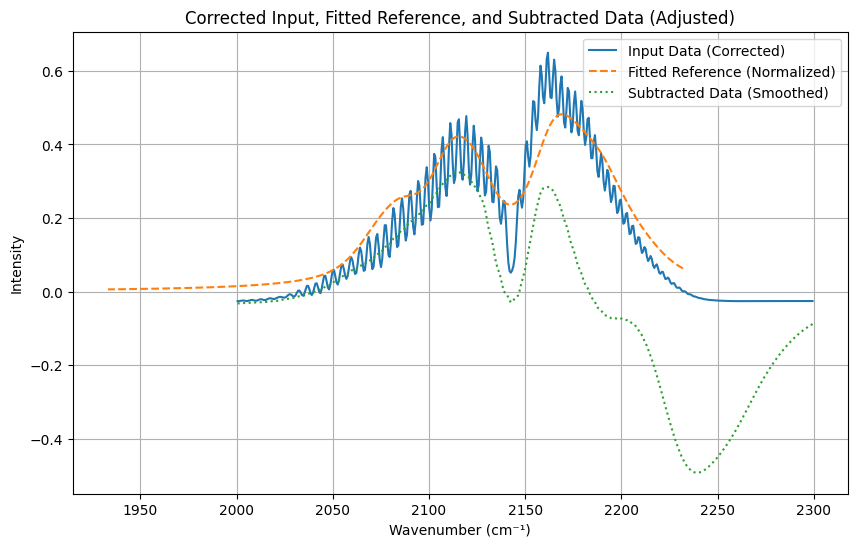

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Define Gaussian Function
def gaussian(A, sigma, xp, x):
    return A * np.exp(-(((x - xp) / sigma) ** 2))

# Define Pseudo-Voigt Profile
def pseudo_voigt(A, sigma, delta, xp, x):
    g = (delta**5 + sigma**5 + 2.69296 * sigma**4 * delta +
         2.42843 * sigma**3 * delta**2 + 4.47163 * sigma**2 * delta**3 +
         0.07842 * sigma * delta**4)**(1 / 5)
    eta = delta / g
    eta = eta * (1.36603 - 0.47719 * eta + 0.11116 * eta**2)
    gaussian_component = A * np.exp(-(((x - xp) / g) ** 2))
    cauchy_component = A / (1 + ((x - xp) / g) ** 2)
    return (1 - eta) * gaussian_component + eta * cauchy_component


# Combined Gaussian and Voigt Summation
def sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode='gaussian'):
    def COEJBM(fregapha, mj, B0, B1, D3):
        return fregapha + (B0 + B1) * mj + (B0 - B1) * mj**2 - 4 * D3 * mj**3

    if mode == 'gaussian':
        return sum(coeff * gaussian(1, sigma, COEJBM(fregapha, i, B0, B1, D3), x)
                   for i, coeff in enumerate(coeffs))
    elif mode == 'voigt':
        return sum(coeff * pseudo_voigt(1, sigma, delta, COEJBM(fregapha, i, B0, B1, D3), x)
                   for i, coeff in enumerate(coeffs))

# Data loading
def import_data(file_path):
    return pd.read_csv(file_path, delimiter="\t", header=None)

# Files
# Files
reference_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0061.0055.dpt"  # Update with your file path
input_file = "/content/drive/MyDrive/Research/Spectroscopy/IR_Spectrum_Predcition/LC0027.0005.dpt"

reference_data = import_data(reference_file)
input_data = import_data(input_file)

# Spectrum selection
spectrum_min, spectrum_max = 2000.0, 2300.0
reference_selected = reference_data[(reference_data[0] >= spectrum_min) & (reference_data[0] <= spectrum_max)]
input_selected = input_data[(input_data[0] >= spectrum_min) & (input_data[0] <= spectrum_max)]

x_ref, y_ref = reference_selected[0].values, reference_selected[1].values
x_in, y_in = input_selected[0].values, input_selected[1].values

# Background Correction
background = np.mean(y_ref[(x_ref >= 2250) & (x_ref <= 2300)])
y_in_corrected = y_in - background

# Fit Model Function
def fit_model(x_data, y_data, mode='gaussian'):
    def model(x, *params):
        coeffs = params[:30]
        fregapha, sigma, delta, B0, B1, D3 = params[30:]
        return sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode=mode)

    initial_params = [0.5] * 30 + [2142.0, 1.5, 1.0, 2.0, 2.0, 0.0001]
    bounds = ([0]*30 + [2000.0, 0.1, 0.1, 0.1, 0.1, 0.0],
              [1]*30 + [2300.0, 10.0, 10.0, 10.0, 10.0, 1.0])

    popt, _ = curve_fit(model, x_data, y_data, p0=initial_params, bounds=bounds, maxfev=100000)
    return popt

# Fit the reference and input data
params_ref = fit_model(x_ref, y_ref, mode='voigt')
params_in = fit_model(x_in, y_in_corrected, mode='voigt')

# Frequency Shift Correction
frecorr = params_in[30] - params_ref[30]
x_in_shifted = x_in - frecorr

# Generate the fitted reference spectrum
def model(x, *params):
    coeffs = params[:30]
    fregapha, sigma, delta, B0, B1, D3 = params[30:]
    return sum_components(coeffs, fregapha, sigma, delta, B0, B1, D3, x, mode='voigt')

fitted_ref = model(x_in_shifted, *params_ref)

# Normalize Intensity
norm_factor = np.sum(y_in_corrected[(x_in >= 2100) & (x_in <= 2200)]) / \
              np.sum(fitted_ref[(x_in_shifted >= 2100) & (x_in_shifted <= 2200)])
fitted_ref_normalized = fitted_ref * norm_factor

# Subtract the fitted reference from the input data
subtracted_data = y_in_corrected - fitted_ref_normalized

# Apply Smoothing
subtracted_data_smoothed = savgol_filter(subtracted_data, window_length=51, polyorder=3)

# Plot the data for visualization
plt.figure(figsize=(10, 6))
plt.plot(x_in, y_in_corrected, label="Input Data (Corrected)")
plt.plot(x_in_shifted, fitted_ref_normalized, label="Fitted Reference (Normalized)", linestyle="--")
plt.plot(x_in, subtracted_data_smoothed, label="Subtracted Data (Smoothed)", linestyle=":")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("Corrected Input, Fitted Reference, and Subtracted Data (Adjusted)")
plt.legend()
plt.grid()
plt.show()
